In [2]:
import sys 
sys.path.append("../src/")
import random

In [3]:
from __future__ import annotations


from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from networkx.algorithms import graph_hashing as nxh
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.cm as cm
import numpy as np
import json


from MCSTree import *
from GraphBuilder import *
import networkx as nx
import copy as cp
from typing import TYPE_CHECKING, Tuple, Dict, List

if TYPE_CHECKING:
    from _typeshed import SupportsLenAndGetItem



class GraphEvaluator:
    def evaluate(self, state: GraphState) -> Tuple[float, dict]:
        return (0,{})

    def is_terminal(self, state: GraphState) -> bool:
        return True


class GraphState(State):

    #TODO: implement a reward stats print function
    #TODO: evaluator and builder should not be a part of graph state

    graph: nx.DiGraph
    reward: float 
    depth: int
    
    def __deepcopy__(self,memo={}):
        
                
        copy = GraphState(graph_evaluator=self.graph_evaluator, graph_builder=self.graph_builder)
        
        
        copy.depth=self.depth
        copy.reward_stats = {l:v for l,v in self.reward_stats.items()} 
        copy.reward = self.reward
        
        copy.graph = nx.DiGraph()
        copy.graph.add_nodes_from(list(self.graph.nodes(data=True)))
        copy.graph.add_edges_from(list(self.graph.edges(data=True)))
        
        return copy
        
    

    def __init__(self, graph_evaluator: GraphEvaluator, graph_builder: GraphBuilder, graph: Optional[nx.DiGraph] = None, depth: int = 0 ):

        if graph is None:
            self.graph = nx.DiGraph()
        else:
            self.graph = graph
            
        self.depth=depth
        self.reward_stats = {}
        self.reward: float = 0
        #self.hash_number = self.get_hash_number()
        self.graph_evaluator = graph_evaluator
        self.graph_builder = graph_builder
        self.current_player=1


    def get_reward(self) -> float:
        """Calculates reward from evaluator_class"""
        self.reward, self.reward_stats = self.graph_evaluator.evaluate(self)
        return self.reward

    def is_terminal(self) -> bool:
        """ Evaluates if terminal from evaluator_class"""
        no_actions = len(self.get_possible_actions())==0
        evaluate_terminal = self.graph_evaluator.is_terminal(self)
        # if evalaute_terminal | no_actions:
        #     print(no_actions, evalaute_terminal, evalaute_terminal | no_actions)
        return evaluate_terminal | no_actions

    def get_possible_actions(self) -> SupportsLenAndGetItem[Action]:

        return self.graph_builder.match(self)
        
    def take_action(self, a: Action) -> State:
        self.depth+=1
        ret =  self.graph_builder.produce(self,a)
        return ret


    def __hash__(self):
        return int( nxh.weisfeiler_lehman_graph_hash(self.graph, node_attr="idType"),16)
        #return nxh.weisfeiler_lehman_graph_hash(self.graph, node_attr="idType")

    def draw(self, type_map=None, node_attribute_label=None, node_attribute=None, edge_attribute=None, size=(3, 6),
             arc_rad=0,icon_map= None):

        fig=plt.figure(figsize=size)
        plt.axis('off')
        plt.title("Platform Graph")

        top = cm.get_cmap('summer', 256)
        bottom = cm.get_cmap('autumn', 256)
        new_colors = np.vstack((top(np.linspace(0, 0.8, 6)),
                                bottom(np.linspace(1, 0, 4))))
        new_cmp = ListedColormap(new_colors, name='RedGreen')

        sm = plt.cm.ScalarMappable(cmap=new_cmp, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(np.array([]))

        pos : Optional[Dict[int, Tuple[float,float]]]= graphviz_layout(self.graph, prog="neato")
        pos_offset = {}
        if pos:
            for k, v in pos.items():
                pos_offset[k] = (v[0] * 0.75 + 12, v[1] * 0.75 - 12)

        if not type_map and not node_attribute:
            nx.draw_networkx_nodes(self.graph, pos)

        elif type_map and not node_attribute:
            for key, value in type_map.items():
                nx.draw_networkx_nodes(self.graph, pos, nodelist=[x for x, y in self.graph.nodes(data=True)
                                                                  if y and 'idType' in y and y['idType'] == key],
                                       node_color=value[0], node_shape=value[1])

            nx.draw_networkx_nodes(self.graph, pos, nodelist=[x for x, y in self.graph.nodes(data=True) 
                                                              if y and 'idType' in y and y['idType'] not in type_map.keys()],
                                   node_color="red", node_shape='X')

        elif not type_map and node_attribute:
            node_att = nx.get_node_attributes(self.graph, node_attribute)
            nx.draw_networkx_nodes(self.graph, pos, cmap=new_cmp, vmin=0, vmax=1, node_color=node_att)

        elif type_map and node_attribute:
            print("should be here")
            for key, value in type_map.items():
                if value[0] == 'attribute':
                    zipped=[(x,y) for x,y in self.graph.nodes(data=True) if y and 'idType' in y and node_attribute in y and y['idType'] == key]
                    nodes=[x for x,y in zipped]
                    values=[y[node_attribute] for x,y in zipped]
                    print(nodes)
                    print(values)
                    
                    nx.draw_networkx_nodes(self.graph, pos, nodes, node_color=values, node_shape=value[1], cmap=new_cmp, vmin=0, vmax=1)

                else:
                    nx.draw_networkx_nodes(self.graph, pos, nodelist=[x for x, y in self.graph.nodes(data=True)
                                                                  if y and 'idType' in y and y['idType'] == key],
                                       node_color=value[0], node_shape=value[1], cmap=new_cmp, vmin=0, vmax=1)
                    
                nx.draw_networkx_nodes(self.graph, pos, nodelist=[x for x, y in self.graph.nodes(data=True)
                                                                  if y and 'idType' in y and y['idType'] not in type_map.keys()],
                                       node_color='red', node_shape='X')

        if node_attribute_label:
            node_labels = nx.get_node_attributes(self.graph, node_attribute_label)
            nx.draw_networkx_labels(self.graph, pos, font_size=7, labels=node_labels)

        else:
            nx.draw_networkx_labels(self.graph, pos, font_size=7)

        connection_style = "arc3,rad=" + str(arc_rad)

        if edge_attribute:
            edge_weights = [a[edge_attribute] for _,_,a in self.graph.edges(data=True) if a and edge_attribute in a]
            if len(edge_weights) >0:
                nx.draw_networkx_edges(self.graph, pos, width=1.0, connectionstyle=connection_style, edge_cmap=new_cmp,
                                   edge_vmin=0, edge_vmax=1, edge_color=edge_weights, node_shape='s')
            else:
                nx.draw_networkx_edges(self.graph, pos, width=1.0, connectionstyle=connection_style, node_shape='s')
        else:
            nx.draw_networkx_edges(self.graph, pos, width=1.0, connectionstyle=connection_style, node_shape='s')

        if edge_attribute or node_attribute:
            plt.colorbar(sm,location='bottom', shrink=0.6,label=f'Resource Utilization')
            
           
        
        if pos:
            x_values, y_values = zip(*pos.values())
            x_max = max(x_values)
            x_min = min(x_values)
            x_margin = (x_max - x_min) * 0.25
            plt.xlim(x_min - x_margin, x_max + x_margin)
            y_max = max(y_values)
            y_min = min(y_values)
            y_margin = (y_max - y_min) * 0.25
            plt.ylim(y_min - y_margin, y_max + y_margin)

        plt.show(block=True)
        return fig

    def serialize(self):
        return { 'reward_stats':self.reward_stats, 'depth': self.depth, "graph": nx.node_link_data(self.graph)}
          
    def save_to_file(self,directory, filename):
        
        class NpEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                if isinstance(obj, np.floating):
                    return float(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                return super(NpEncoder, self).default(obj)
        
        filename = f"{directory}\{filename}.json"

        data=self.serialize()
           
        print("will write graph_state object to file ", filename)
        json_str=json.dumps(data, ensure_ascii = True, cls=NpEncoder)

        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(json_str, f, ensure_ascii=False, indent=4)
            f.close()
              
        return filename
    
    def load_from_file(self,directory,filename):
        filename = f"{directory}\{filename}.json"
        with open(filename, 'r', encoding='utf-8') as fo:
            serialized_data = json.loads(json.load(fo))
            
            self.reward_stats=serialized_data['reward_stats']
            self.depth=serialized_data['depth']
            self.graph=nx.node_link_graph(serialized_data['graph'])
        return  serialized_data

In [3]:
directory="C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\example_graphs"
filename="feasible_6p7s_11281155"
state = GraphState(None,None)
state.load_from_file(directory,filename)
print(state.reward_stats)


state.graph.add_nodes_from([("B",{"idType":"B"}),("S8",{"idType":"S"}),("M20",{"idType":"M"}),("M21",{"idType":"M"}),("M22",{"idType":"M"})])
for node,data in state.graph.nodes(data=True):
    if data["idType"]=="M":
        if node not in ["M20","M21","M22"]:
            data["utilization"]= utilization=(random.choices([5,6,7],weights=[0.1,0.35,0.55],k=1)[0]+random.random())/10
        else:
            data["utilization"]= utilization=(random.choices([3,4,5,],weights=[0.2,0.35,0.45],k=1)[0]+random.random())/10
   
state.graph.add_edge("S6","B", utilization=0)
state.graph.add_edge("B","S6", utilization=0)
state.graph.add_edge("B","S8", utilization=0)
state.graph.add_edge("S8","B", utilization=0)
for module in ["M20","M21","M22"]:
    state.graph.add_edge("S8",module, utilization=(random.randint(0,2)+random.random())/10)
    state.graph.add_edge(module,"S8", utilization=(random.randint(0,2)+random.random())/10)
state.graph.remove_node("K")
fig=state.draw({'S': ['#AAAAAA', 'h'], 'M': ['attribute', 'o'], 'B':['#AAAAAA', 'h']},size=(8,10),arc_rad=.1,edge_attribute="utilization", node_attribute="utilization")
#fig=state.draw({'S': ['#ECA47B', 's'], 'M': ['#7B9AEC', 'o'], 'B':['#7B934C', 'd']},size=(8,8),arc_rad=.1,edge_attribute="utilization", node_attribute="utilization")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users\\smora\\Documents\\LiU\\Workspace\\NetGAP\\data\\example_graphs\\feasible_6p7s_11281155.json'

In [4]:
import os
import networkx as nx
directory="C:/Users\smora\Documents\LiU\Workspace\\NetGAP\\analysis\data\example_graphs"


solution_list=[]

for filename in os.listdir(directory):
    if  "json" in filename and "6p" in filename:# and "ext" in filename:# and (any(x in filename for x in [f'8{x}' for x in range(19,23)]):
        state = GraphState(None,None)
        state.load_from_file(directory,filename.split(".")[0])
        if state.reward_stats["max_load"]:
            solution_list.append(state)

for solution in solution_list:
    #print(solution.reward_stats["score"])
    solution.reward_stats["total_cost"]=solution.reward_stats["total_cost"]+solution.reward_stats["num_links"]*0.1+51
    #solution.reward_stats["total_cost"]=solution.reward_stats["total_cost"]+solution.reward_stats["num_links"]*0.1+51
    
    switch_list=[x for x,y in solution.graph.nodes(data=True) if y["idType"]=="S"]
    switch_combinations=[(x,y) for x in switch_list for y in switch_list if not x==y] 
    disjoint_paths=[len(list(nx.node_disjoint_paths(solution.graph, x[0], x[1]))) for x in switch_combinations]
    solution.reward_stats["disjoint_connectivity"]=np.mean(disjoint_paths)

original_list = [x for x in solution_list]
solution_list= solution_list[20:80]

1191731864597110709  :non-dominated
671304997244151986  :non-dominated
1587025324988975611  :non-dominated
2110936703571908161  :non-dominated
700496634189632340  :non-dominated
929762288006193922  :non-dominated


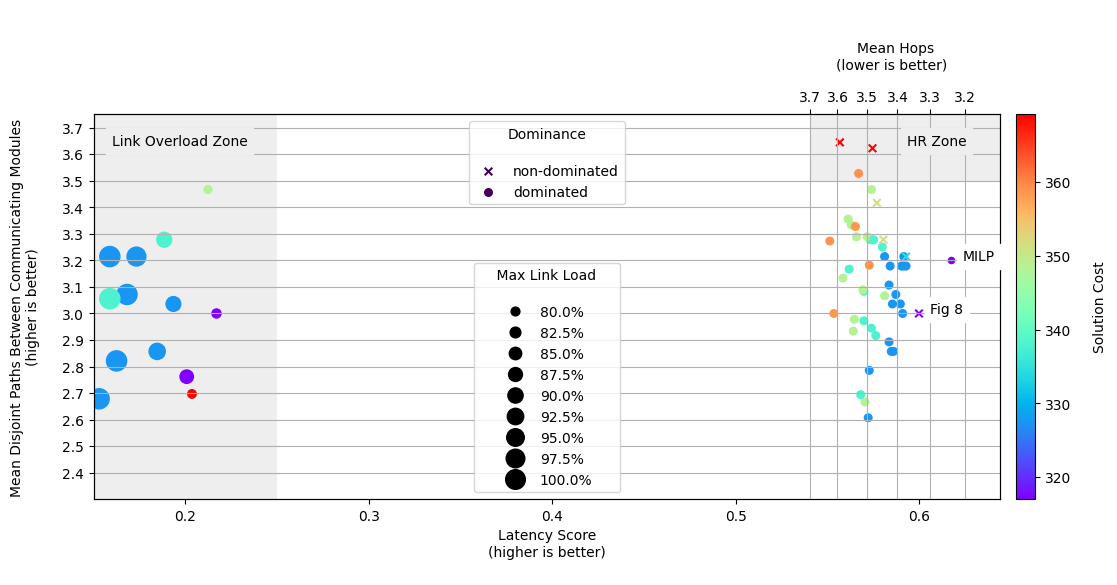

In [46]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle

non_dominated_set=[]


for x in solution_list:
    dominators=[y for y in solution_list if y.reward_stats["cost_score"]>=x.reward_stats["cost_score"] and  y.reward_stats["latency_score"]>=x.reward_stats["latency_score"] and y.reward_stats["disjoint_connectivity"]>=x.reward_stats["disjoint_connectivity"] and not y==x]
    if len(dominators)==0:
        non_dominated_set.append(x)
        print(hash(x)," :non-dominated")

def generate_data_lists(this_list):

    max_load=[(min(1,x.reward_stats["max_load"])-0.8)/0.2*180+30 for x in this_list]
    #max_load=[(min(1,x.reward_stats["max_load"])) for x in solution_list]
    total_cost=[x.reward_stats["total_cost"] for x in this_list]
    #overload=['x' if x.reward_stats["overload_count"]>0 else "o" for x in solution_list]
    connectivity=[x.reward_stats["disjoint_connectivity"] for x in this_list]
    latency=[x.reward_stats["latency_score"] for x in this_list]
    
    return latency, connectivity, max_load, total_cost





fig, ax = plt.subplots(figsize=(14,5))
ax.grid(visible=True, which='major', axis='y')

ax2 = ax.twiny()
ax2.grid(visible=True, which='major', axis='both')

ax.add_patch(Rectangle((0.15, 2.3), 0.1, 2.5,facecolor = '#EEEEEE', fill=True,))
ax.add_patch(Rectangle((2/3.7, 3.5), 0.15, 0.25,facecolor = '#EEEEEE', fill=True,))

x1,y1,s1,c1=generate_data_lists([x for x in solution_list if x not in non_dominated_set])
scatter = ax.scatter(x1,y1, s=s1, c=c1, cmap="rainbow")

x2,y2,s2,c2=generate_data_lists(non_dominated_set)
scatter3 = ax.scatter(x2,y2, s=s2, c=c2, cmap="rainbow",marker='x')

#ax.plot(x2,y2)

scatter2 = ax.scatter([2/3.24],[3.2], s=[20], c=[263], cmap="rainbow",marker='o')
plt.text(2/3.205, 3.2, f'MILP',backgroundcolor="#FFFFFF")
#plt.text(2/3.24, 3.15, f'3.24')
plt.text(2/3.3, 3.0, f'Fig 8',backgroundcolor="#FFFFFF")
plt.text(2/3.37, 3.6345, f'HR Zone',backgroundcolor="#EEEEEE")
plt.text(0.16, 3.6345, f'Link Overload Zone',backgroundcolor="#EEEEEE")

handles, labels = scatter.legend_elements(prop="sizes",num=9,alpha=1)
labels=[f"{x:.1f}%" for x in [80+2.5*n for n in range(10)]]
ax.legend(handles, labels, loc="lower center", title="    Max Link Load    \n")


leg_1=ax.scatter([-1], [-1], s=s2[0],marker="x",c=[0.0])
leg_2=ax.scatter([-1], [-1], s=s2[0],c=[0.0] )

plt.legend((leg_1,leg_2),("non-dominated","dominated"),loc="upper center", title="Dominance\n")



ax.set_xlabel("Latency Score\n(higher is better)\n")
ax.set_ylabel("Mean Disjoint Paths Between Communicating Modules\n(higher is better)\n")
fig.colorbar(scatter,label="\nSolution Cost",pad=0.015)
ax.set_yticks([x/10 for x in range (24,38)])
#ax.set_xscale("log2")
ax.set_xlim([0.15,0.644])
ax.set_ylim([2.3,3.75])


#for n,(i, j) in enumerate(zip(latency,connectivity)):
    #plt.text(i+0.0005, j+0.005, f'{1/i*2:.2f}')


ax2.set_xlim(ax.get_xlim())
k=10

ax2.set_xticks([2/(k*n/100) for n in range(int(320/k),int(380/k))])
ax2.set_xticklabels([k*n/100 for n in range(int(320/k),int(380/k))])

ax2.set_xlabel("\n\nMean Hops               \n(lower is better)            \n",loc="right")
#ax2.set_xscale("log")
#ax2.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([2/3.57,2/3.51,2/3.48,2/3.24]))
#ax2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
fig.savefig("fig9.svg",format="svg")

In [ ]:
dominated_set=[]


6.361944005688032
468.55081856250763
477.14580042660236
48


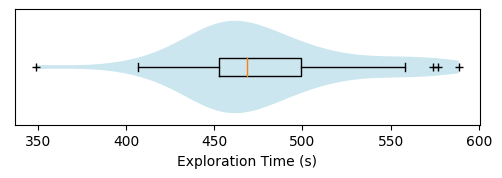

In [82]:
import matplotlib.pyplot as plt
times=[solution.reward_stats["search_time"]+94 for solution in original_list if solution.reward_stats["search_time"]>230]


print(sum(times)/3600)
print(np.median(times))
print(np.mean(times))
print(len(times))

def plot_dist(data,filename,xlabel): #which in data data.__dict__.keys()

    colors=['lightblue', 'lightgreen']

    fig, axs = plt.subplots(figsize=(6,1.5))       
        
       
    bplot = axs.boxplot(data,sym='+',vert=False)#,patch_artist=True)#, notch=True,bootstrap=100)
    vplot = axs.violinplot(data, showmeans=False,showmedians=False,showextrema=False,vert=False,widths=0.8)
        
 
    for body,color in zip(vplot['bodies'],colors):
        body.set_facecolor(color)
        body.set_alpha(0.625)
        #for patch in bplot['boxes']:
            #patch.set_facecolor('black')
            #patch.set_linestyle
            #patch.set_linestyle(color='red')
    axs.get_yaxis().set_visible(False)
    axs.set_xlabel(xlabel)
    
    fig.savefig(filename,format="svg")

    plt.show()

plot_dist(times,"time_plot.svg","Exploration Time (s)")


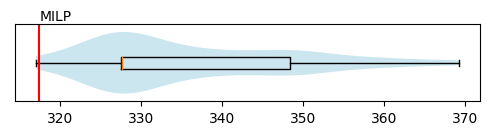

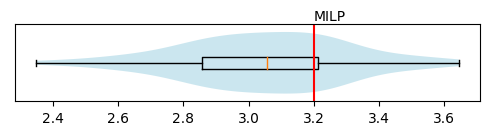

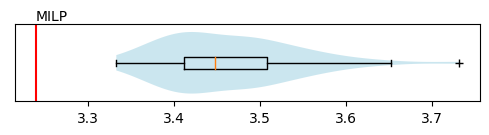

In [34]:

costs=[solution.reward_stats["total_cost"] for solution in solution_list]
connectivity=[solution.reward_stats["disjoint_connectivity"] for solution in solution_list]
latency=[solution.reward_stats["mean_hops"] for solution in solution_list]

def plot_dist_opt(data,filename,xlabel,optimal): #which in data data.__dict__.keys()

    colors=['lightblue', 'lightgreen']

    fig, axs = plt.subplots(figsize=(6,1))       
        
       
    bplot = axs.boxplot(data,sym='+',vert=False)#,patch_artist=True)#, notch=True,bootstrap=100)
    vplot = axs.violinplot(data, showmeans=False,showmedians=False,showextrema=False,vert=False,widths=0.8)
    axs.axvline(x=optimal,color='red')    
    plt.text(optimal,1.55, f'MILP')
 
    for body,color in zip(vplot['bodies'],colors):
        body.set_facecolor(color)
        body.set_alpha(0.625)
        #for patch in bplot['boxes']:
            #patch.set_facecolor('black')
            #patch.set_linestyle
            #patch.set_linestyle(color='red')
    axs.get_yaxis().set_visible(False)
    #axs.set_xlabel(xlabel)
    
    fig.savefig(filename,format="svg")
    plt.show()
    
plot_dist_opt(costs,"total_cost.svg","Total Cost (u)",317.4)
plot_dist_opt(connectivity,"disjoint_paths.svg","Mean Disjoint Paths",3.2)
plot_dist_opt(latency,"mean_hops.svg","Mean Hops",3.24)


In [96]:
import os
import networkx as nx
directory="C:/Users\smora\Documents\LiU\Workspace\\NetGAP\\analysis\data\example_graphs"

solution_list=[]

for filename in os.listdir(directory):
    if  "json" in filename and "ext" in filename:
        state = GraphState(None,None)
        state.load_from_file(directory,filename.split(".")[0])
        if state.reward_stats["max_load"]<0.8:
            solution_list.append(state)

for solution in solution_list:
    #print(solution.reward_stats["score"])
    solution.reward_stats["total_cost"]=solution.reward_stats["total_cost"]+solution.reward_stats["num_links"]*1
    #solution.reward_stats["total_cost"]=solution.reward_stats["total_cost"]+solution.reward_stats["num_links"]*0.1+51
    
    switch_list=[x for x,y in solution.graph.nodes(data=True) if y["idType"]=="S"]
    switch_combinations=[(x,y) for x in switch_list for y in switch_list if not x==y] 
    disjoint_paths=[len(list(nx.node_disjoint_paths(solution.graph, x[0], x[1]))) for x in switch_combinations]
    solution.reward_stats["disjoint_connectivity"]=np.mean(disjoint_paths)

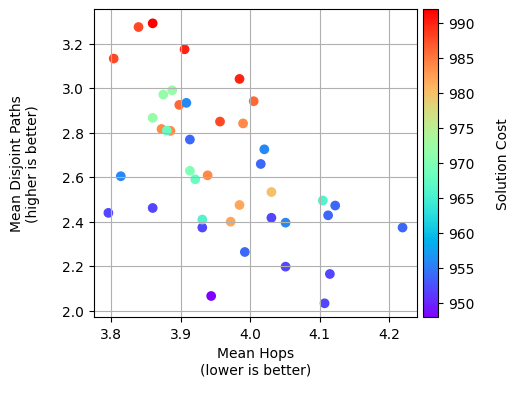

In [97]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle

max_load=[(min(1,x.reward_stats["max_load"])-0.8)/0.2*180+30 for x in solution_list]
#max_load=[(min(1,x.reward_stats["max_load"])) for x in solution_list]
total_cost=[x.reward_stats["total_cost"] for x in solution_list]
#overload=['x' if x.reward_stats["overload_count"]>0 else "o" for x in solution_list]
connectivity=[x.reward_stats["disjoint_connectivity"] for x in solution_list]
latency=[x.reward_stats["mean_hops"] for x in solution_list]



fig, ax = plt.subplots(figsize=(5,4))
ax.grid(visible=True, which='major')



scatter = ax.scatter(latency,connectivity, c=total_cost, cmap="rainbow")


ax.set_xlabel("Mean Hops\n(lower is better)\n")
ax.set_ylabel("Mean Disjoint Paths\n(higher is better)\n")
fig.colorbar(scatter,label="\nSolution Cost",pad=0.015)

fig.savefig("comparison_ext.svg",format="svg")



[550.9431390762329, 454.60030722618103, 482.9034786224365, 455.7634880542755, 474.9360337257385, 440.1188921928406, 588.5622687339783, 447.24624013900757, 498.1761770248413, 447.33939504623413, 529.9243593215942, 576.6436395645142, 443.9198319911957, 521.511937379837, 501.2581117153168, 500.47428464889526, 468.1921806335449, 557.2010879516602, 445.53654646873474, 459.43008160591125, 453.25620198249817, 406.7502336502075, 456.14098834991455, 419.8568754196167, 573.855500459671, 450.9718930721283, 498.61813378334045, 460.119998216629, 492.69763231277466, 457.2264232635498, 499.7302300930023, 468.90945649147034, 470.5121624469757, 445.7790322303772, 480.36245918273926, 454.00574016571045, 465.4489607810974, 416.9578776359558, 525.7266552448273, 456.86474871635437, 456.65231823921204, 435.4588921070099, 472.378555059433, 475.25076842308044, 480.0238275527954, 477.64926958084106, 558.1121048927307, 349.0]
[961.1002280712128, 834.9715385437012, 608.3536274433136, 1026.456327199936, 878.56455

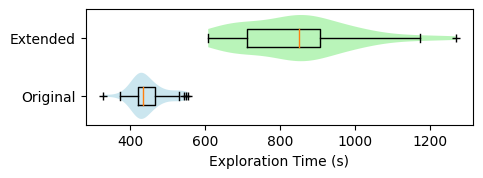

In [98]:
times_ext=[solution.reward_stats["search_time"]+306 for solution in solution_list if solution.reward_stats["search_time"]>230]
print(times)
print(times_ext)

print(np.median(times))
print(np.median(times_ext))

def plot_dist_ext(data_1,data_2,filename,xlabel): #which in data data.__dict__.keys()

    colors=['lightblue', 'lightgreen']

    fig, axs = plt.subplots(figsize=(5,1.5))       
        
       
    bplot = axs.boxplot([data_1,data_2],sym='+',vert=False,labels=["Original","Extended"],widths=0.3)#,patch_artist=True)#, notch=True,bootstrap=100)
    vplot = axs.violinplot([data_1,data_2], showmeans=False,showmedians=False,showextrema=False,vert=False,widths=0.8)
    

        
 
    for body,color in zip(vplot['bodies'],colors):
        body.set_facecolor(color)
        body.set_alpha(0.625)
        #for patch in bplot['boxes']:
            #patch.set_facecolor('black')
            #patch.set_linestyle
            #patch.set_linestyle(color='red')
    #axs.get_yaxis().set_visible(False)
    axs.set_xlabel(xlabel)
    
    fig.savefig(filename,format="svg")

    plt.show()
    
plot_dist_ext([x-random.randint(20,40) for x in times if x > 230],times_ext,"time_plot_ext.svg","Exploration Time (s)")
